In [1]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.neighbors import KNeighborsClassifier

import scvi
import scanpy as sc
from datetime import datetime
from tqdm import tqdm
from pathlib import Path

from scipy.optimize import nnls

/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/lightning/fabric/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 42
np.random.seed(random_seed)


# Step 0: Load the data

In [3]:
path_data_train = pl.Path("data/train_data")
path_data_test = pl.Path("data/test_data")

In [4]:
train_bulk = pd.read_csv(path_data_train / "train_bulk.csv",index_col=0)
train_bulk_trueprops = pd.read_csv(path_data_train / "train_bulk_trueprops.csv",index_col=0)
train_adata = sc.read_h5ad(path_data_train / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data_test / "test_adata.h5ad")
test_bulk = pd.read_csv(path_data_test / "test_bulk.csv",index_col=0)


In [5]:
print(f"Number of patients to deconvolve: {train_bulk.shape[1]}")
print(f"Number of genes in dataset: {train_bulk.shape[0]}")

Number of patients to deconvolve: 12
Number of genes in dataset: 7725


In [6]:
print(train_adata.obs.shape)
train_adata.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [7]:
train_adata.var.head()

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


In [8]:
print(train_bulk.shape)
train_bulk.head()

(7725, 12)


,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


In [9]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs["Sample"].unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs["Sample"]==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [10]:
print(f"There are {train_adata.obs["highLevelType"].nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs["highLevelType"].unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


In [11]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs["Sample"].unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs["Sample"]==spl].n_obs}")

Number of cells in the test set 18616
Number of cells for s5 is 6020
Number of cells for s6 is 5530
Number of cells for s9 is 3336
Number of cells for s10 is 3730


In [12]:
train_bulk.head()

,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


# Step 1: Perform SC clustering 

Define which columns are considered as target and which for the batch effect.

In [13]:
label_key = "highLevelType"
categorical_covariate_keys = ["Sample", "Tumor status", "Patient"]
batch_key = "Sample"

Filter genes with low activation

In [14]:
sc.pp.filter_genes(train_adata, min_cells=3)


Normalize the data and log-transform it

In [15]:

train_adata.layers["counts"] = train_adata.X.copy()  # preserve counts
sc.pp.normalize_total(train_adata, target_sum=1e4)
sc.pp.log1p(train_adata)
train_adata.raw = train_adata

Only select the most variable genes across cells. This will dimensions and therefore help for the training (speed up)

In [16]:
sc.pp.highly_variable_genes(
    train_adata,
    flavor="seurat_v3",
    n_top_genes=1200,
    subset=True,
    layer="counts",
    batch_key=batch_key,
)

Prepare the model for training by defining the label keys and the keys to take into account for the batch effect

In [17]:
scvi.model.SCVI.setup_anndata(
    train_adata,
    layer="counts",
    labels_key=label_key,
    categorical_covariate_keys=categorical_covariate_keys,
)

model = scvi.model.SCVI(train_adata)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

Train the model for maximum 200 epochs using early stopping, or used a saved version.

In [18]:
TRAIN = False # set to True to train the model from scratch
if TRAIN:
    model.train(early_stopping=True, max_epochs=200, check_val_every_n_epoch=10)
else:
    model_filename = Path("data/model/20251128-161857_scvi_model")
    model = scvi.model.SCVI.load(str(model_filename), train_adata)
    print("Model loaded from disk.")

INFO     File data/model/20251128-161857_scvi_model/model.pt already downloaded                                    
Model loaded from disk.


Save the trained model

In [19]:
if TRAIN:
    tstamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    model_filename = Path(f"data/model/{tstamp}_scvi_model")
    model.save(str(model_filename))

Get the latent representation of the training data and store it.

In [20]:
Z_train = model.get_latent_representation()

train_adata.obsm["X_scVI"] = Z_train

The following code aims to show the batch correction introduced by scVI. In this first part we simply plot the data without performing the trasformation done by scVI.

In [21]:
sc.tl.pca(train_adata)

In [22]:
sc.pp.neighbors(train_adata, n_pcs=30, n_neighbors=20, use_rep="X_pca")
sc.tl.umap(train_adata, min_dist=0.3, random_state=random_seed)

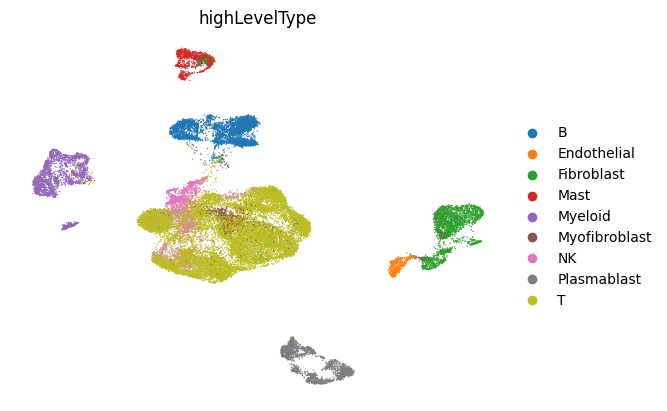

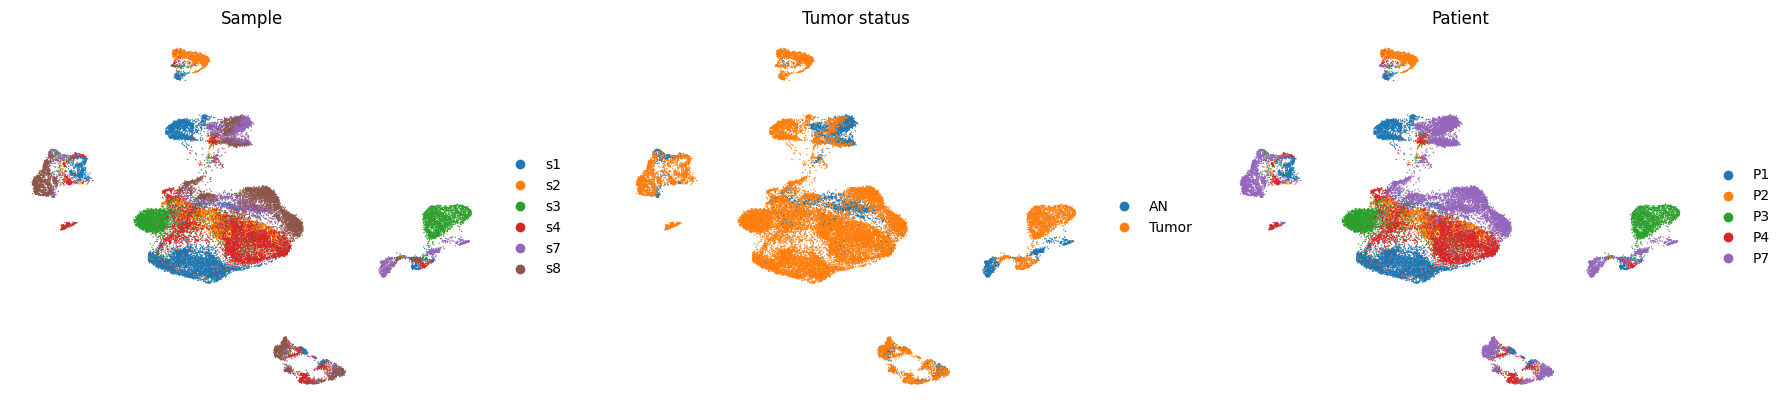

In [23]:
sc.pl.umap(
    train_adata,
    color=[label_key],
    frameon=False,
)

sc.pl.umap(
    train_adata,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys),
)

From the plots above we observe the batch effect: we can see that different samples are kept separated, although the cluster are already biologically quite meaningful (when looking at the cell types plot).7

In the next code blocks, we plot instead the results from the scVI.

In [24]:
sc.pp.neighbors(train_adata, use_rep="X_scVI")
sc.tl.umap(train_adata, min_dist=0.3, random_state=random_seed)

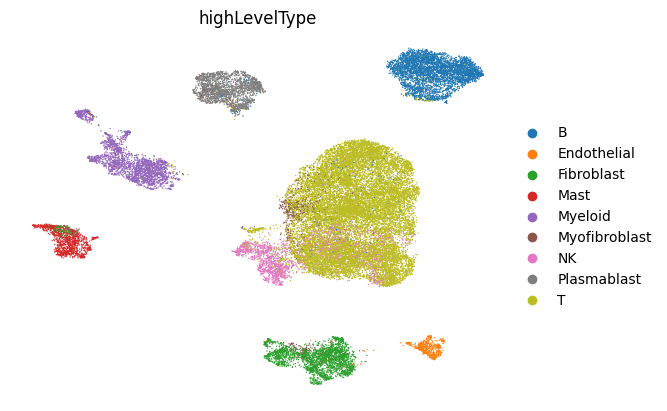

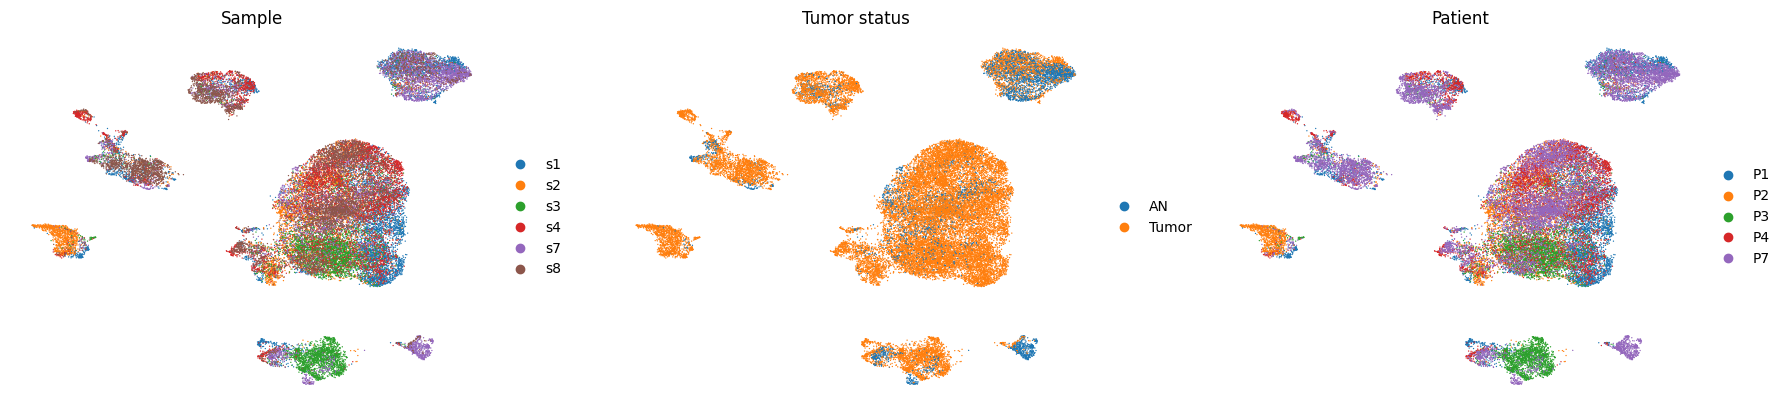

In [25]:
sc.pl.umap(
    train_adata,
    color=[label_key],
    frameon=False
)

sc.pl.umap(
    train_adata,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys)
)

This looks much better! The samples are well mixed and the cell types are still quite well separated.

We then use Leiden algorithm for clustering. To choose the best resolution, we run it multiple times with different values and use the task metrics to evaluate the performance. 

In [30]:
# resolution search helper

def get_custer_score(adata, res, true_labels):
    sc.tl.leiden(adata, resolution=res, key_added="leiden_tmp", random_state=random_seed)
    pred_labels = adata.obs["leiden_tmp"].to_numpy()
    ari = adjusted_rand_score(true_labels, pred_labels)
    v = v_measure_score(true_labels, pred_labels)
    score = (ari + v) / 2
    return score

def search_best_resolution(adata, true_label_key=label_key, shrinkage=0.5, iters=30, low=0.2, high=1.5):
    assert shrinkage < 1.0 and shrinkage > 0.0, "shrinkage must be in (0,1)"

    true_labels = adata.obs[true_label_key].to_numpy()
    best_score = -1.0
    best_res = 1
    tmp = adata.copy()

    low_score = get_custer_score(tmp, low, true_labels)
    high_score = get_custer_score(tmp, high, true_labels)

    for i in tqdm(range(iters)):
        if low_score > high_score:
            score = low_score
            res = low
        else:
            score = high_score
            res = high

        if score > best_score:
            best_score = score
            best_res = res
            print(f"New best resolution: {best_res} with score: {best_score}")


        if low_score > high_score:
            high = (shrinkage * high + (1 - shrinkage) * low)
            high_score = get_custer_score(tmp, high, true_labels)
        else:
            low = ((1 - shrinkage) * high + shrinkage * low)
            low_score = get_custer_score(tmp, low, true_labels)

    if low_score > high_score:
        score = low_score
        res = low
    else:
        score = high_score
        res = high

    if score > best_score:
        best_score = score
        best_res = res
        print(f"New best resolution: {best_res} with score: {best_score}")

    return best_res, best_score

best_res, best_score = search_best_resolution(train_adata, true_label_key=label_key, shrinkage=0.8, iters=20, low=0.01, high=1)
print("Best resolution chosen (train):", best_res, "score:", best_score)

  0%|          | 0/20 [00:00<?, ?it/s]

New best resolution: 0.01 with score: 0.6626527148208423


 50%|█████     | 10/20 [03:27<03:05, 18.52s/it]

New best resolution: 0.11630044057600009 with score: 0.8089022560422376


 70%|███████   | 14/20 [04:18<01:28, 14.73s/it]

New best resolution: 0.07275978011607044 with score: 0.8100826566639836


100%|██████████| 20/20 [05:31<00:00, 16.57s/it]

Best resolution chosen (train): 0.07275978011607044 score: 0.8100826566639836


The following shows the clusters using the best resolution found.

In [31]:
sc.tl.leiden(train_adata, resolution=best_res, random_state=random_seed)

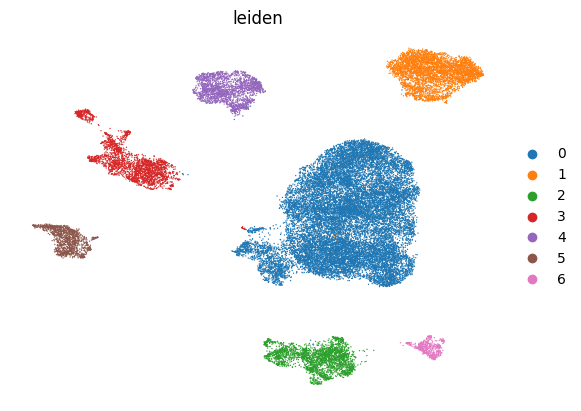

In [32]:
sc.pl.umap(
    train_adata,
    color=['leiden'],
    frameon=False
)


## Step 1bis: Predict on test data


We perform the same preprocessing on the test set

In [33]:
selected_genes = train_adata.var_names.tolist()

test_adata = test_adata[:, selected_genes].copy()
test_adata.layers["counts"] = test_adata.X.copy()  
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)
test_adata.raw = test_adata

In [34]:
test_adata.obs[label_key] = "Unknown"
model_test = scvi.model.SCVI.load_query_data(
    test_adata,
    model,
)

And we train it for a few epochs on the test set.

In [35]:
model_test.train(max_epochs=20)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [00:57<00:00,  2.86s/it, v_num=1, train_loss=541]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:57<00:00,  2.88s/it, v_num=1, train_loss=541]


Get the latent representation and store it

In [36]:
test_adata.obsm["X_scVI"] = model_test.get_latent_representation()

We assign the cluster to the test data considering the 5 nearest neighbors in the latent space. The cluster assigned to a test point (cell) is the one mostly assigned to these 5 nearest neighbors

In [37]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_adata.obsm["X_scVI"], train_adata.obs["leiden"])
test_adata.obs['knn_cluster'] = knn.predict(test_adata.obsm["X_scVI"])

Show the result

In [38]:
sc.pp.neighbors(test_adata, use_rep="X_scVI")
sc.tl.umap(test_adata, min_dist=0.3, random_state=random_seed)

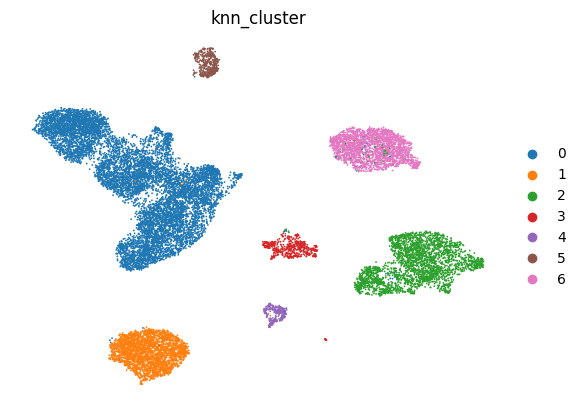

In [39]:
sc.pl.umap(
    test_adata,
    color=['knn_cluster'],
    frameon=False,
    ncols=1
)

Finally we store the predictions in the right format

In [40]:
cluster_labels = test_adata.obs[["knn_cluster"]].reset_index().rename(columns={"knn_cluster": "cluster"})
cluster_labels

,index,cluster
0,AAACCCAAGGAGGCAG-1_5,0
1,AAACCCAAGTTGCGCC-1_5,0
2,AAACCCACACGGATCC-1_5,0
3,AAACCCACATCGGAAG-1_5,0
4,AAACCCAGTGCGAGTA-1_5,0
...,...,...
18611,TTTGGTTCATTGAAGA-1_10,0
18612,TTTGGTTGTTGTCCCT-1_10,2
18613,TTTGGTTGTTTGACAC-1_10,0
18614,TTTGTTGAGGGTCAAC-1_10,0


# Step 2: Deconvolve the data

To deconvolve the data we first create a reference matrix (gene expression per cell type) by performing a supervised deconvolution using non-negative least squares on the proportion and bulk data.

The reference matrix is then used to perform a supervised deconvolution on the test data.

In [41]:
CELL_ORDER = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast', 'NK', 'Myeloid', 'Mast']  

def create_reference_matrix(true_props: pd.DataFrame, bulk_data: pd.DataFrame):
    """
    Create reference matrix from bulk data and true proportions using NNLS.
    """

    ref_matrix = pd.DataFrame(
        index=bulk_data.index, # gene
        columns=true_props.index, # cell type
    )
    
    for gene in bulk_data.index:
        b = bulk_data.loc[gene].to_numpy()
        A = true_props.to_numpy().T
        
        gex, _ = nnls(A, b)
        
        ref_matrix.loc[gene] = gex
    
    return ref_matrix[CELL_ORDER]


def deconvolve(bulk_data: pd.DataFrame, reference_matrix: pd.DataFrame):
    """
    Deconvolve bulk RNA-seq data using NNLS.
    
    Parameters:
    - bulk_data: DataFrame with genes as rows, samples as columns
    - reference_matrix: DataFrame with genes as rows, cell types as columns
    Returns:
    - DataFrame with cell types as rows, samples as columns (proportions)
    """
    # Find common genes
    common_genes = bulk_data.index.intersection(reference_matrix.index)
    print(f"Using {len(common_genes)} common genes for deconvolution")
    
    # Subset to common genes
    bulk_subset = bulk_data.loc[common_genes].copy()
    ref_subset = reference_matrix.loc[common_genes].copy()
    
    
    # Initialize results
    proportions = pd.DataFrame(
        index=ref_subset.columns,
        columns=bulk_subset.columns
    )
    
    # Deconvolve each sample
    for sample in bulk_subset.columns:
        bulk_profile = bulk_subset[sample].to_numpy()
        ref_matrix = ref_subset.to_numpy()
        
        props, _ = nnls(ref_matrix, bulk_profile)
        
        # Normalize to sum to 1
        props = props / props.sum() if props.sum() > 0 else np.ones(len(props)) / len(props)
        proportions[sample] = props
    
    return proportions.loc[CELL_ORDER]



ref_matrix = create_reference_matrix(train_bulk_trueprops, train_bulk)
train_props_pred = deconvolve(train_bulk, ref_matrix)

print("Train predictions:")
train_props_pred


Using 7725 common genes for deconvolution
Train predictions:


,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
highLevelType,,,,,,,,,,,,
T,0.590247,0.456106,0.541924,0.588814,0.102125,0.696079,0.459816,0.313904,0.749475,0.626629,0.109679,0.267629
Endothelial,0.015696,0.000000,0.011401,0.001241,0.012964,0.019356,0.009688,0.000000,0.089904,0.095905,0.061142,0.053722
Fibroblast,0.184405,0.198834,0.049646,0.079176,0.000000,0.057808,0.099733,0.132329,0.038827,0.017099,0.002156,0.023518
Plasmablast,0.013588,0.195016,0.000000,0.009018,0.096762,0.000848,0.001708,0.022246,0.072878,0.081239,0.050305,0.022157
B,0.043358,0.000000,0.139130,0.072455,0.279991,0.050717,0.000000,0.000000,0.011212,0.104560,0.518367,0.408002
Myofibroblast,0.000000,0.036490,0.050292,0.125703,0.072323,0.102557,0.081165,0.070566,0.000000,0.000000,0.046670,0.054170
NK,0.041780,0.064814,0.029307,0.046511,0.291716,0.071454,0.272537,0.255328,0.000000,0.000000,0.166530,0.159147
Myeloid,0.025083,0.000000,0.016221,0.011865,0.144119,0.000000,0.061059,0.205626,0.025362,0.056048,0.038305,0.000000
Mast,0.085844,0.048740,0.162080,0.065216,0.000000,0.001182,0.014294,0.000000,0.012341,0.018521,0.006846,0.011655


We evaluate the performance on the training set

Evaluation on training data:
Mae mean: [0.02910689 0.00258356 0.00533184 0.00176431 0.00072232 0.02438624
 0.00049192 0.00038448 0.00023212]
Mean Absolute Error (MAE): 0.0488
Root Mean Squared Error (RMSE): 0.0850
Task Benchmark Score (TB): 0.0641

Per-cell-type MAE:
  T: 0.1334
  Fibroblast: 0.0462
  NK: 0.0567
  Myeloid: 0.0345
  Mast: 0.0202
  B: 0.1031
  Myofibroblast: 0.0191
  Endothelial: 0.0168
  Plasmablast: 0.0094


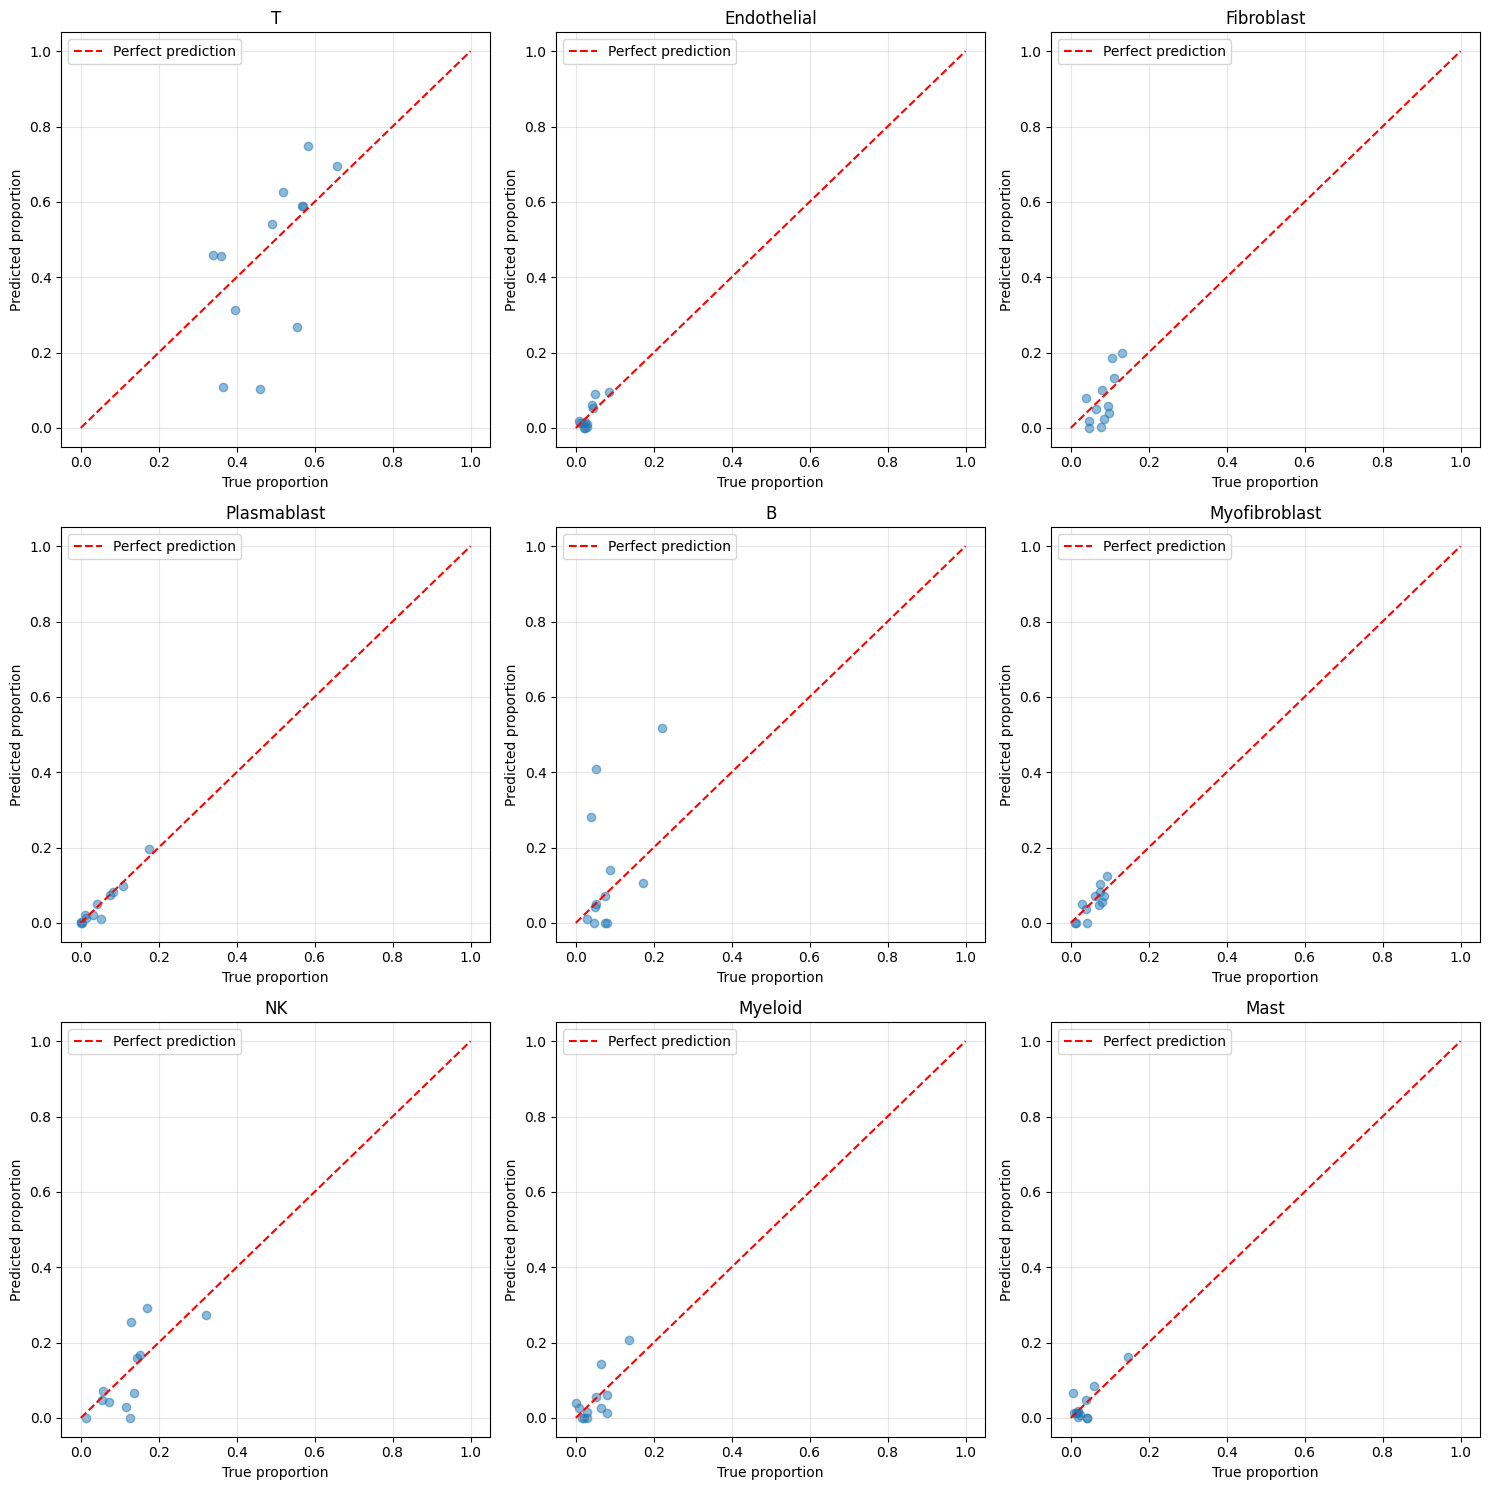

In [42]:
# Evaluate performance on training data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def task_benchmark_score(true_props: pd.DataFrame, pred_props: pd.DataFrame):
    mae = (true_props.values - pred_props.values) ** 2
    print("Mae mean:", mae.mean(axis=1))
    return np.sqrt(mae.mean(axis=1).astype('float32')).mean()

def evaluate_deconvolution(true_props, pred_props):
    """Calculate performance metrics for deconvolution"""
    # Ensure same order
    common_samples = true_props.columns.intersection(pred_props.columns)
    common_celltypes = true_props.index.intersection(pred_props.index)
    
    true = true_props.loc[common_celltypes, common_samples]
    pred = pred_props.loc[common_celltypes, common_samples]
    
    mse = mean_squared_error(true.values.flatten(), pred.values.flatten())
    mae = mean_absolute_error(true.values.flatten(), pred.values.flatten())
    tb = task_benchmark_score(true, pred)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Task Benchmark Score (TB): {tb:.4f}")
    
    # Per cell type performance
    print("\nPer-cell-type MAE:")
    for ct in common_celltypes:
        ct_mae = mean_absolute_error(true.loc[ct], pred.loc[ct])
        print(f"  {ct}: {ct_mae:.4f}")
    
    return mae, rmse

print("Evaluation on training data:")
evaluate_deconvolution(train_bulk_trueprops, train_props_pred)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ct in enumerate(train_props_pred.index):
    ax = axes[idx]
    ax.scatter(train_bulk_trueprops.loc[ct], train_props_pred.loc[ct], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
    ax.set_xlabel('True proportion')
    ax.set_ylabel('Predicted proportion')
    ax.set_title(f'{ct}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Step 2bis: Predict on the test data

To make predictions for the test data we follow the same procedure as on the train data, using the reference matrix we computed before.

In [46]:
# Deconvolve test bulk data
print("Deconvolving test bulk data...")
test_props_pred = deconvolve(test_bulk, ref_matrix)
print(f"Test proportions shape: {test_props_pred.shape}")
test_props_pred = test_props_pred.reset_index().rename(columns={"highLevelType": "index"})
print("\nTest predictions:")
test_props_pred

Deconvolving test bulk data...
Using 7725 common genes for deconvolution
Test proportions shape: (9, 20)

Test predictions:


,index,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,...,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
0,T,0.279966,0.544888,0.548547,0.512297,0.562389,0.528983,0.540306,0.569924,0.541547,...,0.548819,0.500886,0.523233,0.580755,0.552808,0.441331,0.458823,0.440578,0.484305,0.433373
1,Endothelial,0.075351,0.042401,0.045434,0.048386,0.044722,0.055161,0.050716,0.050235,0.051692,...,0.084177,0.085344,0.084915,0.082509,0.084970,0.091222,0.086951,0.089532,0.092615,0.085860
2,Fibroblast,0.040364,0.062921,0.057811,0.063758,0.055581,0.066115,0.067027,0.075322,0.075348,...,0.117207,0.084623,0.106356,0.107835,0.130922,0.070803,0.068018,0.068301,0.084765,0.069868
3,Plasmablast,0.036372,0.000471,0.016623,0.008442,0.007905,0.000986,0.001447,0.000920,0.000619,...,0.001891,0.002620,0.001094,0.003077,0.000006,0.003617,0.004429,0.007430,0.013719,0.000000
4,B,0.212112,0.259516,0.198993,0.210784,0.230070,0.266946,0.258459,0.210443,0.245071,...,0.197640,0.277858,0.213719,0.163223,0.165125,0.321258,0.313005,0.331877,0.224832,0.361210
5,Myofibroblast,0.020693,0.062239,0.065841,0.061664,0.057565,0.056256,0.076706,0.067410,0.061321,...,0.038645,0.026793,0.032962,0.032640,0.043809,0.054130,0.063631,0.052435,0.061112,0.047845
6,NK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Myeloid,0.335142,0.026740,0.064586,0.094668,0.033798,0.007162,0.004472,0.014665,0.010758,...,0.011621,0.012485,0.036092,0.029961,0.022360,0.014481,0.000310,0.009847,0.034778,0.000000
8,Mast,0.000000,0.000825,0.002165,0.000000,0.007969,0.018391,0.000868,0.011080,0.013644,...,0.000000,0.009392,0.001630,0.000000,0.000000,0.003159,0.004834,0.000000,0.003874,0.001845


# Step 3: Save the required files

In [47]:
assert len(test_props_pred.columns) == len(test_bulk.columns) + 1, "Length mismatch: expected {} but got {}".format(len(test_bulk.columns) + 1, len(test_props_pred.columns))
assert all(test_props_pred.columns == np.append(["index"], test_bulk.columns)), "Wrong columns"

In [48]:
assert all(test_props_pred['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [49]:
assert all(test_props_pred.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [50]:
assert all(cluster_labels.columns == ["index", "cluster"]), "Wrong columns"

In [51]:
assert all(cluster_labels["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [53]:
import zipfile

first_name = "Paolo"
last_name = "Laffranchi"
tstamp = datetime.now().strftime("%Y%m%d_%H%M%S")

results_path = pl.Path("data/submissions/")
archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_submission.zip"

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        test_props_pred.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()

print(f"Submission archive saved to {results_path / archive_name}")

archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_code.zip"

files_mapping = {
    "main.ipynb": "main.ipynb",
    "README.md": "README.md",
    "requirements.txt": "requirements.txt",
    "uv.lock": "uv.lock",
    ".python-version": ".python-version",
    "pyproject.toml": "pyproject.toml",
}

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    for fname, arcname in files_mapping.items():
        zf.write(fname, arcname)
    zf.close()

print(f"Code archive saved to {results_path / archive_name}")


Submission archive saved to data/submissions/20251128_175708_Paolo_Laffranchi_Project2_submission.zip
Code archive saved to data/submissions/20251128_175708_Paolo_Laffranchi_Project2_code.zip
